## E796: CNN for event classification

### Reading the data with pyROOT

In [24]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample, shuffle

<BarContainer object of 2 artists>

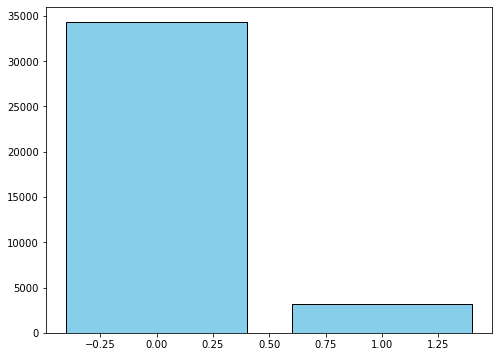

In [13]:
rdf = r.RDataFrame("Dataset", "dataset.root")
dictionary = rdf.AsNumpy(["x", "y", "z", "label"])

x = np.array(dictionary["x"])
y = np.array(dictionary["y"])
z = np.array(dictionary["z"])
xy = np.column_stack((x, y))
labels = np.array(dictionary["label"])

# Plot distribution of labels
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts, color='skyblue', edgecolor='black')

In [27]:
#Select events

zeros = xy[labels == 0]
ones = xy[labels == 1]

zeros_downscaled = resample(zeros, replace=False, n_samples=len(ones), random_state=42)

xy_downscaled = np.vstack((zeros_downscaled, ones))
labels_downscaled = np.hstack((np.zeros(len(zeros_downscaled)), np.ones(len(ones))))

In [59]:
# And shuffle events
xy_suffled, labels_shuffled = shuffle(xy_downscaled, labels_downscaled, random_state=42)

# Build dense data
nentries = len(xy_suffled)
grid_size = 128
grid = np.zeros((nentries, grid_size, grid_size), dtype=int)
for row, sparse in enumerate(xy_suffled):
    for i,j in zip(sparse[0], sparse[1]):
            grid[row, i,j] = 1

# And add grayscale as last axis
grid_ok = grid.reshape(-1, grid_size, grid_size, 1)

### Building the CNN model

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten

In [62]:
model = Sequential([
    Input(shape=(grid_size, grid_size, 1)),
    Conv2D(128, (5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (2,2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Summary of the model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,129 (781.75 KB)

 Trainable params: 200,129 (781.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# And train!
model.fit(grid_ok, labels_shuffled, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 97s 602ms/step - accuracy: 0.6530 - loss: 0.6245 - val_accuracy: 0.7927 - val_loss: 0.5456
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 101s 629ms/step - accuracy: 0.7963 - loss: 0.5193 - val_accuracy: 0.8207 - val_loss: 0.5031
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 103s 639ms/step - accuracy: 0.8303 - loss: 0.4597 - val_accuracy: 0.8323 - val_loss: 0.4770
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 101s 628ms/step - accuracy: 0.8448 - loss: 0.4379 - val_accuracy: 0.8307 - val_loss: 0.4695
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 101s 626ms/step - accuracy: 0.8638 - loss: 0.3827 - val_accuracy: 0.8230 - val_loss: 0.4947
Epoch 6/10
139/161 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - accuracy: 0.8800 - loss: 0.3456